<a href="https://colab.research.google.com/github/ImagingDataCommons/idc-radiomics-reproducibility/blob/dev/notebooks/pai_complete_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook showcases a processing example of the pipeline published in [Pai et Al. - *Foundation Models for Quantitative Biomarker Discovery in Cancer Imaging*](https://www.medrxiv.org/content/10.1101/2023.09.04.23294952v1), reproduced with the tools provided by the Imaging Data Commons and the Google Cloud Platform.

The goal of this notebook is to provide the user with an example of how such tools can be used to run an AI/ML end-to-end analysis on cohorts hosted by the Imaging Data Commons portal, and to describe what we identified as the best practices to do so.


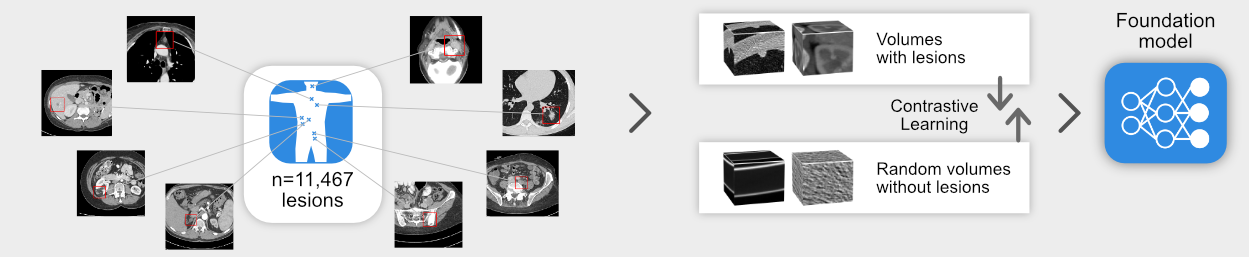

The notebook is part of the [IDC Radiomics Reproducibility](https://github.com/ImagingDataCommons/idc-radiomics-reproducibility) repository. If you use the code found in this notebook or you want to refer to some of our findings, please cite:

> Dennis Bontempi, Leonard Nuernberg, Deepa Krishnaswamy, Ahmed Hosny, Keyvan Farahani, Ron Kikinis, Andriy Fedorov, Hugo Aerts - _Transparent and Reproducible AI-based Medical Imaging Pipelines Using the Cloud_

As well as the original paper:

> Suraj Pai, Dennis Bontempi, Vasco Prudente, Ibrahim Hadzic, Mateo Sokač, Tafadzwa L. Chaunzwa, Simon Bernatz, Ahmed Hosny, Raymond H Mak, Nicolai J Birkbak, Hugo JWL Aerts - _Foundation Models for Quantitative Biomarker Discovery in Cancer Imaging_


---

The Imaging Data Commons GCS buckets are free to access and download from - but in order to run the BigQuery query and proceed, we need to authenticate with a Google Account. Running this notebook will be completely free.

Additional documentation regarding the Imaging Data Commons and its integration with the Google Cloud Platform can be found at the following page: https://learn.canceridc.dev/portal/getting-started

In [ ]:
from google.colab import auth
auth.authenticate_user()

Another essential to run the analyses is to have a Google Cloud Project setup in the account we authenticated with. Setting up a GCP project is free and take seconds. To learn how to create a project (for free) and get started with IDC, you can visit the following resources:

* [Create a Google Cloud Project](https://developers.google.com/workspace/guides/create-project)
* [Getting started with IDC](https://learn.canceridc.dev/getting-started-with-idc)



Before proceeding with the notebook, **remember to set** `my_ProjectID` **to the ID of your project!**

In [ ]:
# initialize this variable with your Google Cloud Project ID!
my_ProjectID = "idc-sandbox-000"

---

# Environment Setup

In this section, we are going to take care of the environment setup: making sure all of the dependencies are installed and working, creating the directory tree we need to run the pipeline, and so on.

Depending on how many Colab credits you have, you can either run this notebook using a CPU or a GPU. The processing times are relatively fast, so attaching a GPU to this Colab instance is not mandatory.

If you want to access the free GPUs Colab provides, you can do so at:
`Edit > Notebooks Settings`.

From the dropdown menu under `Hardware accelerator`, select `GPU`. Let's check the Colab instance is indeed equipped with a GPU.

In [ ]:
# check wether the use of a GPU was correctly enabled
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "not found" in gpu_list[0] else True

---

Next, we will need to install the few dependencies the notebook relies on. Note how most of the python packages we will use (e.g., `numpy`, `matplotlib`, ...) are nowadays part of the base Colab installation, and therefore won't need setup.


We can start by installing the `foundation-cancer-image-biomarker` package prepared by the authors. This will take care of the installation of several other python dependencies, and provide useful functions we will use troughout the notebook.

In [ ]:
%%capture
%pip install foundation-cancer-image-biomarker --pre -U

---

# Reproducing the Study

This section of the notebook showcases a complete reproduction of the pipeline published in Pai et Al. If you are interested in learning more about the pipeline, we suggest you take a look at our `processing_example` notebook [at this link](https://colab.research.google.com/github/ImagingDataCommons/idc-radiomics-reproducibility/blob/main/notebooks/pai_processing_example.ipynb), where we provide an in-depth breakdown of all the steps in the processing pipeline and show some examples of the latter, or visit the project repository [at this link](https://github.com/AIM-Harvard/foundation-cancer-image-biomarker/tree/master).



To reproduce the study in its entirety we will need to download two datasets from the Imaging Data Commons: NSCLC-Radiomics (LUNG1) and NSCLC-Radiogenomics. Make sure the Colab instance you are running (either on the cloud or from a local runtime) has enough space to do so. All of the public data used in this study was downloaded from the Imaging Data Commons (IDC). In the other notebooks at the [IDC Radiomics Reproducibility](https://github.com/ImagingDataCommons/idc-radiomics-reproducibility) repository, we downloaded datasets hosted on IDC using BigQuery and the `%%bigquery` IPython Magic as seen in the example provided as part of the [IDC tutorial series](https://github.com/ImagingDataCommons/IDC-Tutorials). As part of this tutorial, since the authors of the paper shared the cohort manifest files and utility functions to download the cohort from IDC, we are going to use such files and functions (`download_LUNG1` and `download_RADIO`).

Then, we will need to pre-process the datasets, i.e., convert the DICOM data to NIfTI and extract seed points centered around the tumoural lesions. Once that is taken care of, we will extract the deep features for the each of the CT volumes by running the foundation model presented in the paper. In order to do so, we will use the seed point to crop a volume around it.

As a last step, we will download the clinical data for the LUNG1 and the NSCLC-Radiogenomics dataset to define a target variable (e.g., 2-years survival), use the linear model shared by the authors to predict survival probability, and plot the results.

We can start by importing all the necessary modules from the `foundation-cancer-image-biomarker` package. These modules provide utilities for downloading the LUNG1 dataset, loading models, running inference and visualization of steps in the pipeline.

In [ ]:
from fmcib.utils import download_LUNG1, download_RADIO, build_image_seed_dict
from fmcib.datasets import get_lung1_clinical_data, get_radio_clinical_data
from fmcib.datasets import get_lung1_foundation_features, get_radio_foundation_features

from fmcib.models import resnet50, get_linear_classifier

from fmcib.preprocessing import preprocess
from fmcib.run import get_features

import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


Please cite:
Thomas Phil, Thomas Albrecht, Skylar Gay, & Mathis Ersted Rasmussen. (2023). Sikerdebaard/dcmrtstruct2nii: dcmrtstruct2nii v5 (Version v5). Zenodo. https://doi.org/10.5281/zenodo.4037864



## Load the Pre-trained Models
The next cells take care of downloaing and loading the pre-trained ResNet50 foundation model shared by the authors, by using the `resnet50` utility function from `fmcib.models`, and the linear model trained on top of the foundation model deep features (validated on the internal dataset `HarvardRT`).

In [ ]:
model = resnet50(device="cpu")

2023-10-20 10:41:34.881 | INFO     | fmcib.models.resnet50:resnet50:19 - Loading pretrained foundation model (Resnet50) on cpu...


Downloading: 100% [738451713 / 738451713] bytes

In [ ]:
linear_model = get_linear_classifier()

Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


## Run the Pipeline for LUNG1


We can start by downloading the NSCLC-Radiomics (also known as LUNG1) dataset from the Imaging Data Commons.

We are going to convert the downloaded DICOM files into NIfTI and extract the seed points. As this processing is compute-intensive, it can takes some time to run in its entirety. Feel free to uncomment the feature extraction steps and run it - or use the code below to fetch the pre-computed features (for visualization purposes).

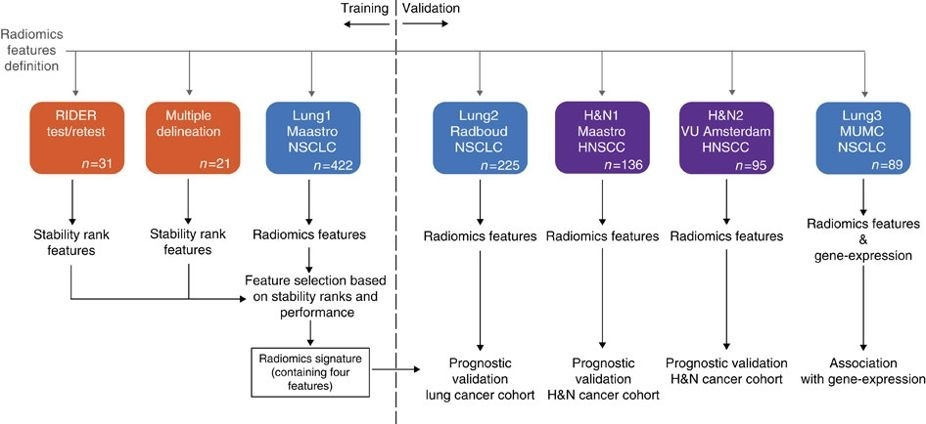


To download the dataset, we fetch a preconfigured manifest file obtained from the Imaging Data Commons (https://datacommons.cancer.gov/repository/imaging-data-commons) and then pull the DICOM data from google cloud storage into the folder specified using the `download_LUNG1` utility function.

To learn how the authors generated the manifest file, you can follow [this notebook](https://colab.research.google.com/drive/1AsRLdNCW_m20DRzQBFCBFSieGJthV8nu?usp=sharing). This can be used for other cohorts on IDC as well, allowing you to test additional datasets with the foundation models in this notebook.

The DICOM data is sorted into the following structure:
````
<Download Folder>
├── PatientID
    ├── StudyInstanceUID
        └──  List of dicom files with the format <Modality>_<SeriesInstanceUID>_<InstanceNumber>

````

Additional details regarding this dataset are available [here](https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics).


In [ ]:
# download_LUNG1("lung1") # Takes about 15 mins to download
# lung1_df = build_image_seed_dict("lung1") # Takes about 1.5 hours to process entire dataset
# lung1_feature_df = get_features(lung1_df)

lung1_feature_df = get_lung1_foundation_features()

Please note the clinical data fetched for comparison purposes is an exact copy obtained from [here](https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics).

In [ ]:
lung1_clinical_df = get_lung1_clinical_data()
lung1_clinical_df["survival"] = (lung1_clinical_df["Survival.time"]/365.0 >= 2).astype(int)

# Merge features with clinical data
lung1_combined_df = pd.merge(lung1_feature_df, lung1_clinical_df, how="inner", on="PatientID")
lung1_combined_df.dropna(inplace=True, subset=["survival"])

Finally, we can use the deep features we extracted with the foundation model to make a prediction and plot a the Area Under the Receiver Operating Characteristic Curve.

In [ ]:
lung1_features = lung1_feature_df[[f"pred_{idx}" for idx in range(4096)]]
lung1_probs = linear_model.predict_proba(lung1_features)[:, 1]

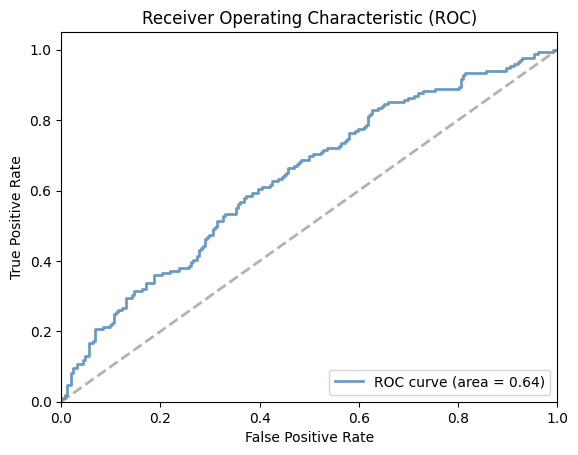

In [ ]:
plt.figure()
lw = 2
fpr, tpr, thresholds = roc_curve(lung1_combined_df["survival"], lung1_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="steelblue", lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.8)

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Run the Pipeline for NSCLC-Radiogenomics

We can now do the same for the NSCLC-Radiogenomics dataset.

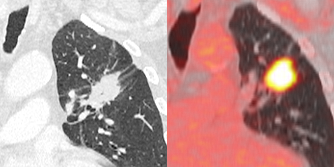


Once again, we fetch a preconfigured manifest file from Imaging Data Commons (https://datacommons.cancer.gov/repository/imaging-data-commons) and then pull the DICOM data from google cloud storage into the folder specified using the `download_RADIO` utility function.

The DICOM data is sorted into the following structure:
````
<Download Folder>
├── PatientID
    ├── StudyInstanceUID
        └──  List of dicom files with the format <Modality>_<SeriesInstanceUID>_<InstanceNumber>

````

Additional details regarding this dataset can be found [here](https://wiki.cancerimagingarchive.net/display/Public/NSCLC+Radiogenomics).

The following cells will convert the downloaded DICOM files into NIfTI and extract the seed points. As this processing is compute-intensive, it can takes some time to run in its entirety. Feel free to uncomment the feature extraction steps and run it - or use the code below to fetch the pre-computed features (for visualization purposes).

In [ ]:
# download_RADIO("radio") # Takes about 15 mins to download
# radio_df = build_image_seed_dict("radio") # Takes about 1.5 hours to process entire dataset
# radio_feature_df = get_features(radio_df)

radio_feature_df = get_radio_foundation_features()

Columns (20,41) have mixed types. Specify dtype option on import or set low_memory=False.


Please note the clinical data fetched for comparison purposes is an exact copy obtained from [here](https://wiki.cancerimagingarchive.net/display/Public/NSCLC+Radiogenomics).

In [ ]:
from datetime import datetime
radio_clinical_df = get_radio_clinical_data() # Clinical data fetched is an exact copy obtained from https://wiki.cancerimagingarchive.net/display/Public/NSCLC+Radiogenomics

# Compute survival time
radio_clinical_df["Date of Last Known Alive"] = radio_clinical_df["Date of Last Known Alive"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
radio_clinical_df["CT Date"] = radio_clinical_df["CT Date"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
radio_clinical_df["Survival.time"] = (radio_clinical_df["Date of Last Known Alive"] - radio_clinical_df["CT Date"]).apply(lambda x: x.days)
# radio_clinical_df["Survival.time"] = radio_clinical_df["Survival.time.days"].apply(lambda x: x.days)

radio_combined_df = pd.merge(radio_feature_df, radio_clinical_df, how="inner", left_on="PatientID", right_on="Case ID")
radio_combined_df["survival"] = (radio_combined_df["Survival.time"]/365.0 >= 2).astype(int)
radio_combined_df.dropna(inplace=True, subset=["survival"])

Finally, we can use the deep features we extracted with the foundation model to make a prediction and plot a the Area Under the Receiver Operating Characteristic Curve.

In [ ]:
radio_features = radio_combined_df[[f"pred_{idx}" for idx in range(4096)]]
radio_probs = linear_model.predict_proba(radio_features)[:, 1]

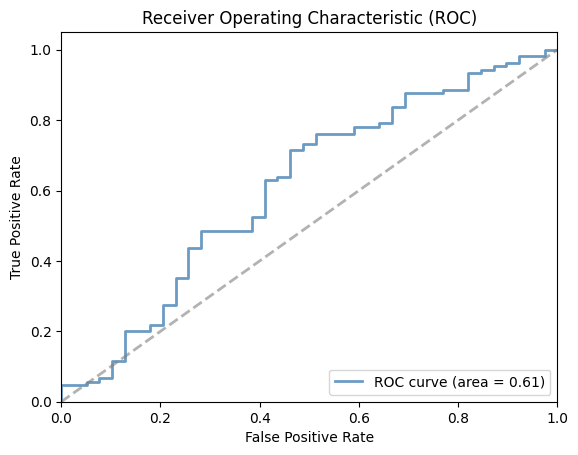

In [ ]:
plt.figure()
lw = 2
fpr, tpr, thresholds = roc_curve(radio_combined_df["survival"], radio_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="steelblue", lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.8)

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()